This script computes the kernel-based interpolants based on the so-called fake nodes or mapped bases. 

We consider the multivariate scattered data interpolation problem. Given a set of scattered data $X_{n}=\{\boldsymbol{x}_i, \; i=1, \ldots,n \} \subseteq \Omega$, with $\Omega \in \mathbb{R}^d$ and the associated function values 
$F_{n}=\{f(\boldsymbol{x}_i), \; i=1, \ldots,n \}$, which are sampled from a function $f$, find a function $P_f$ so that 
\begin{equation*}
    P_f(\boldsymbol{x}_i) = f(\boldsymbol{x}_i), \quad i=1, \ldots, n. 
\end{equation*}

Let us consider an injective map $S: \Omega \longrightarrow \mathbb{R}$. The idea is to construct an interpolant  $$R_f \in H^s_n := \textrm{span}(K(\cdot,S(\boldsymbol{x}_1)), \ldots, K(\cdot,S(\boldsymbol{x}_n))),$$ so that for $\boldsymbol{x} \in \Omega$ $$ R_f(\boldsymbol{x})=  \sum_{i=1}^n \alpha^s_i K(\cdot,S(\boldsymbol{x}_i)):= P_g(S(\boldsymbol{x})),$$
and the (unknown) function $g$ is such that $g_{|S(X_n)}=f_{|X_n}.$ Thus constructing the interpolant $R_f$ via the mapped bases is equivalent to  building a classical interpolant $P_g \in H_n $ on the fake nodes $S(X_n)$ and thus solving the associated collocation system with the given function values as right-hand side.


In [4]:
# Import the needed packages
import numpy as np
import matplotlib.pylab as plt

In [5]:
# Define the MSE
def mse(ftrue, fapprox, N):
    return np.sum(((np.power(ftrue-fapprox, 2))))/N
# Define the test function
def funcval(x,y):
    return np.array([(np.sin(x+y**2))*(x**2+y**2-0.4**2<0)+\
                     (1)*(x**2+y**2-0.4**2>=0)]).T

We now define the function for computing the distance matrices and the kernel used in our experiments, i.e. $\Phi({\boldsymbol{x}},{\boldsymbol{y}})= \exp(-||\boldsymbol{x}-\boldsymbol{y}||_2)$ 

In [6]:
# Function for computing the distance matrices
def DistanceMatrix(dsites,epoints,dim):
    DM = np.zeros((dsites.shape[0], dsites.shape[0]))
    DM_eval = np.zeros((epoints.shape[0], dsites.shape[0]))
    for count in range(0,dim):
        dr, cc = np.meshgrid(epoints[:,count],dsites[:,count])
        DM_eval = DM_eval + (np.power((dr-cc),2)).T
        dr, cc = np.meshgrid(dsites[:,count],dsites[:,count])
        DM = DM + (np.power((dr-cc),2)).T
    return DM, DM_eval
# Define the kernel
def _rbfm(ep, r):
    return np.exp(-ep*r)

In [11]:
# Define the input parameters
N = 40 # Fix the number of evaluation points in one direction
ShiftParameter = 10 # Shift parameter
arr = np.array([3,9,17,33]) # Fix the number of points in one direction
ep = 0.5 # Fix the shape parameter
dim = 2 # Fix the dimension
# Compute the function values for testin the performances of the method
TrueSolution, MseStandard, MseFakeNodes = [], [], [] # Initialize

In [12]:
# Compute the grid for the evaluation points
X, Y = np.meshgrid(np.transpose(np.linspace(-1,1,N)),\
                   np.transpose(np.linspace(-1,1,N)))
X, Y = X.ravel(), Y.ravel()
TrueSolution = funcval(X,Y)
# Compute the fake evaluation nodes
mask = X**2+Y**2-0.4**2>0 # This mask is associated to the test function
XF, YF = X.copy(), Y.copy() 
# Compute the fake evaluation nodes
XF[mask] = X[mask]+ShiftParameter
YF[mask] = Y[mask]+ShiftParameter

In [13]:
# Compute the approximants
for j in range(0,len(arr)):
    # Define the number of points
    n = int(arr[j])
    # Construct the grid of interpolation points
    x, y = np.meshgrid(np.transpose(np.linspace(-1,1,n)),\
                           np.transpose(np.linspace(-1,1,n)))    
    x, y = x.ravel(), y.ravel()
    # Compute the function values    
    f = funcval(x,y) 
    # Compute the kernel matrices for standard interpolation
    DM, DM_eval= DistanceMatrix(((np.vstack((x,y)).T)+1)/2,((np.vstack((X,Y)).T)+1)/2,dim)
    IM, EM = _rbfm(ep,np.sqrt(DM)), _rbfm(ep,np.sqrt(DM_eval))    
    # Compute the coefficient of the interpolant    
    coef = np.linalg.solve(IM,f)
    # Evaluate the interpolant
    lsp = EM.dot(coef)    
    # Compute the MSE
    MseStandard = np.hstack((MseStandard,\
                              mse(lsp, TrueSolution, (lsp.shape[0]))))
    # Compute the fake evaluation nodes
    xF, yF = x.copy(), y.copy() # Initialize
    mask = x**2+y**2-0.4**2>0
    xF[mask] = x[mask]+ShiftParameter
    yF[mask] = y[mask]+ShiftParameter
    # Compute the kernel matrices for standard interpolation
    DM, DM_eval= DistanceMatrix((((np.vstack((xF,yF))/np.max((np.max(xF), \
    (np.max(yF))))).T)+1)/2,(((np.vstack((XF,YF))/np.max((np.max(XF),\
    (np.max(YF))))).T)+1)/2,dim)
    IM, EM = _rbfm(ep,np.sqrt(DM)), _rbfm(ep,np.sqrt(DM_eval))    
    # Compute the coefficient of the interpolant    
    coef = np.linalg.solve(IM,f)
    # Evaluate the interpolant
    lsp = EM.dot(coef)      
    # Compute the MSE
    MseFakeNodes = np.hstack((MseFakeNodes,\
                               mse(lsp, TrueSolution, (lsp.shape[0])))) 

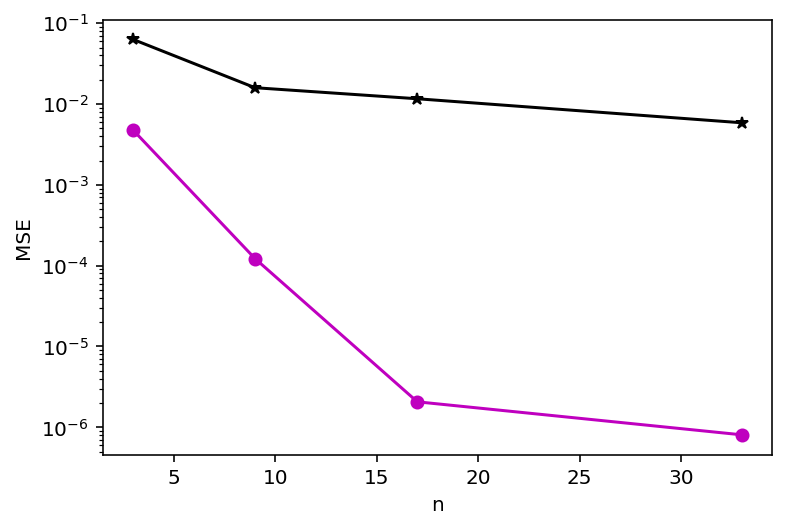

In [14]:
# Save the results  
Outfile = open('ResultsKernel.txt',"w")
out_string = 'MSE with standard nodes: %s\n' %(MseStandard)
out_string += 'MSE with fake nides: %s\n' %(MseFakeNodes)
Outfile.write(out_string)   
Outfile.close()
# Plot
plt.semilogy(arr, MseStandard, 'k*-',arr, MseFakeNodes,'mo-')
plt.xlabel('n')
plt.ylabel('MSE')
plt.savefig("ErrorKernel.eps")
plt.show()